In [65]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from functools import reduce
import time
from multiprocessing import Pool
import scipy.linalg

import sys
sys.path.insert(0, '../')

from utils import *

In [66]:
def make_noise(sigma2, m):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(m) + 1j*noise_scaling*np.random.randn(m)
    return noise
def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def make_signal(signal, k, N, p, ms):
    return [round(signal[(2**p + m) % N] * np.conj(signal[m % N]), 4) for m in ms]
    #return [round(np.exp(1j*(2*np.pi*k / N)*(2**p + m))*np.conj(np.exp(1j*(2*np.pi*k / N)*(m))), 4) for m in ms]

N = 8
clean_signal = [[np.exp(1j*(2*np.pi*k*m / N))  for k in range(N)] for m in range(N)]
sigma2 = get_sigma2_from_snrdb(100)
noises = [make_noise(sigma2, N) for i in range(N)]
noisy_signal = [[a + b for a, b in zip(cle, noi)] for cle, noi in zip(clean_signal, noises)]
ms = [i for i in range(3)]
for i in range(N):
    print(i, make_signal(noisy_signal[i], i, N, 0, ms))


0 [(1-0j), (1+0j), (1-0j)]
1 [(0.7071+0.7071j), (0.7071+0.7071j), (0.7071+0.7071j)]
2 [(-0+1j), 1j, (-0+1j)]
3 [(-0.7071+0.7071j), (-0.7071+0.7071j), (-0.7071+0.7071j)]
4 [(-1-0j), (-1+0j), (-1-0j)]
5 [(-0.7071-0.7071j), (-0.7071-0.7071j), (-0.7071-0.7071j)]
6 [(-0-1j), -1j, (-0-1j)]
7 [(0.7071-0.7071j), (0.7071-0.7071j), (0.7071-0.7071j)]


In [75]:
def nthRootsOfUnity(n): 
    return np.exp(2j * np.pi / n * np.arange(n))
def detect_freq(noisy_signal, ms, base, exp):
    N = base ** exp
    all_possible = [True for i in range(N)]
    for i in range(1, exp+1):
        roots = nthRootsOfUnity(2 ** i)
        avg_sig = np.mean(make_signal(noisy_signal, None, N, exp - i, ms))
        dists = [np.abs(r - avg_sig) for r in roots]
        min_dist, min_ind = np.inf, 0
        for j in range(len(roots)):
            if all_possible[j] and dists[j] < min_dist:
                min_dist = dists[j]
                min_ind = j
        for j in range(len(all_possible)):
            if all_possible[j] and (j % len(roots) != min_ind):
                all_possible[j] = False
    return [i for i in range(len(all_possible)) if all_possible[i]][0]

base, exp = 2, 10
N = base ** exp
clean_signal = [[np.exp(1j*(2*np.pi*k*m / N))  for k in range(N)] for m in range(N)]
SNRdB = 2
sigma2 = get_sigma2_from_snrdb(SNRdB)
noises = [make_noise(sigma2, N) for i in range(N)]
noisy_signal = [[a + b for a, b in zip(cle, noi)] for cle, noi in zip(clean_signal, noises)]
#snrs = [3, 2, 1, 0, -1, -2]
m_vals = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
accs = []
for m_val in m_vals:
    print(m_val)
    ms = [i for i in range(m_val)]
    count = 0
    for i in range(N):
        guess = detect_freq(noisy_signal[i], ms, base, exp)
        if guess == i:
            count += 1
        else:
            print(m_val, i, guess)
    print(count / (N))
    accs.append(count / N)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_xlabel('Samples per iteration') 
ax.set_ylabel('Test set classification accuracy')
ax.plot(m_vals, accs, '-go')
ax.set_title('New log^2 method at {}^{} signal length, at {} SNR dB'.format(base, exp, SNRdB))
plt.show()

MemoryError: 

In [61]:
def test_kays(signals, freqs, N, m, T=5):
    count1, count2 = 0, 0
    total_time = 0
    for sig, freq in zip(signals, freqs):
        res, time = kays_method(sig)
        total_time += time
        res = int(round(res * N / (2 * np.pi))) % N
        if freq == res:
            count1 += 1
        if freq == int(test_min_thresh(sig, N, m, res, T)):
            count2 += 1
    return count2 / len(signals), total_time
snrs = [2, 4, 6, 8, 10, 12]
base, exp = 2, 12
N = base ** exp
m = exp * exp
clean_signal = [[np.exp(1j*(2*np.pi*k*m / N))  for k in range(N)] for m in range(N)]
freqs = [i for i in range(N)]
kay_accs, new_accs = [], []
for SNRdB in snrs:
    sigma2 = get_sigma2_from_snrdb(SNRdB)
    noises = [make_noise(sigma2, N) for i in range(N)]
    noisy_signals = [[a + b for a, b in zip(cle, noi)] for cle, noi in zip(clean_signal, noises)]
    noisy_signals = np.array(noisy_signals)
    acc, time = test_kays(noisy_signals[:, :m], freqs, N, m, T=6)
    kay_accs.append(acc)
    print(SNRdB, acc)
    count = 0
    for i in range(N):
        guess = detect_freq(noisy_signals[i], [i for i in range(exp)], base, exp)
        if guess == i:
            count += 1
    print(SNRdB, count / N)
    new_accs.append(count / N)

2 0.08349609375
2 0.999267578125
4 0.30126953125
4 1.0
6 0.646240234375
6 1.0
8 0.868408203125
8 1.0
10 0.966552734375
10 1.0
12 0.99853515625
12 1.0


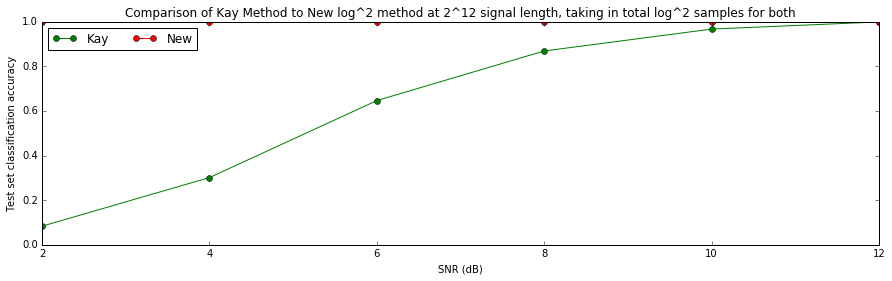

In [64]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
ax.set_xlabel('SNR (dB)') 
ax.set_ylabel('Test set classification accuracy')
ax.plot(snrs, kay_accs, '-go', label='Kay')
ax.plot(snrs, new_accs, '-ro', label='New')
ax.set_title('Comparison of Kay Method to New log^2 method at {}^{} signal length, taking in total log^2 samples for both'.format(base, exp))
plt.legend(loc='best',
           ncol=3)
plt.show()